In [85]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

import wandb

from dots.experiment import run_experiment, get_model, get_optimiser, get_loss_fn
from dots.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
import wandb
import torch as t
import torch.utils.data as tdata
from dots.training import train, TrainState
from dots.utils import range_batch, get_device
from dots.datasets import get_dataset
from dots.models import *

In [87]:
config = {
    "model_class": "MLP",
    "model": {
        "in_size": 1,
        "hidden": [10],
        "out_size": 1,
        "bias": True
    },
    "hp": {
        "optimiser": "Adam",
        "optimiser_args" : {
            "lr": 0.001
        },
        "loss_fn": "MSELoss",
        "epochs": 10,
        "batch_size": 16
    },
    "dataset": {
        "name": "relu",
        "train_test_val_split": [0.8, 0.1, 0.1]
    }
}


In [88]:
run = wandb.init(project="DOTS", group="testing", config=config)

In [89]:
ts = run_experiment(config, wandb=wandb)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▆▇█▆▅▃▄▃▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,9
step,499
train_loss,0.01716


/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/dots/dots/notebooks/../dots/training.py:230: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


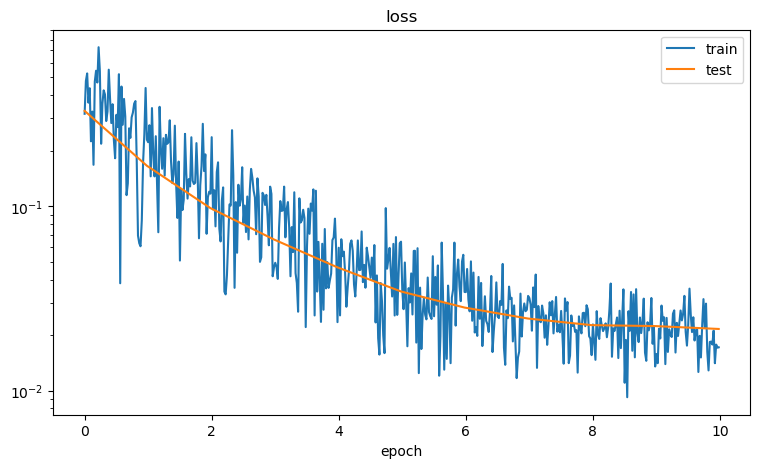

In [90]:
ts.plot()

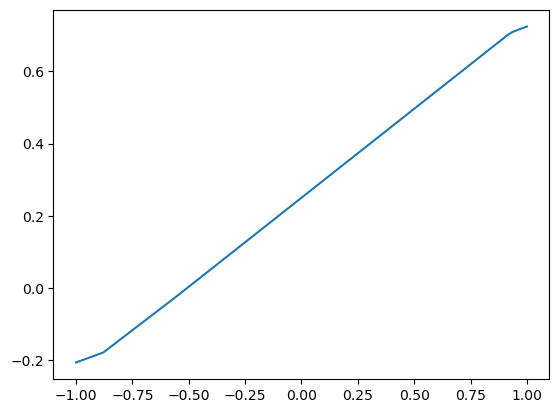

In [91]:
plot_1d_fn(ts.model)

# DEBUGGING:

In [65]:
dataset = get_dataset(config["dataset"]["name"])
dataset_split_sizes = [
    int(frac * len(dataset)) 
    for frac in config["dataset"]["train_test_val_split"]
]

if config.get("seed") is not None:
    t.manual_seed(config.seed)

# want dataset shuffle to be done after seeding:
train_ds, test_ds, valid_ds = tdata.random_split(
    dataset, 
    lengths = dataset_split_sizes
)
train_dataloader = tdata.DataLoader(
    train_ds,
    batch_size=config["hp"]["batch_size"],
    shuffle=True
)
test_dataloader = tdata.DataLoader(
    test_ds,
    batch_size=config["hp"]["batch_size"],
    shuffle=True
)
valid_dataloader = tdata.DataLoader(
    valid_ds,
    batch_size=config["hp"]["batch_size"],
    shuffle=True
)

device = get_device()
model = get_model(config["model_class"])(**config["model"])
model.to(device)

optimiser = get_optimiser(config["hp"]["optimiser"])(
    model.parameters(),
    **config["hp"]["optimiser_args"]
)
loss_fn = get_loss_fn(config["hp"]["loss_fn"])()

train_state = TrainState(
    model,
    optimiser,
    loss_fn,
    train_dataloader,
    test_dataloader,
    hooks = [],
    add_test_train_hooks = True,
    wandb = wandb
)


In [69]:
len(dataset)

1000

In [68]:
len(train_dataloader)

50

In [67]:
len(test_loader)

7

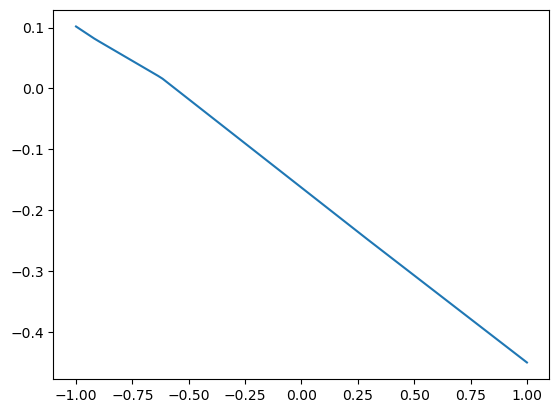

In [72]:
plot_1d_fn(model)

In [75]:
x = range_batch(-1, 1, 100)
loss_fn(model(x), t.relu(x))

tensor(-0., grad_fn=<DivBackward1>)

In [84]:
t.nn.MSELoss()(model(x), t.relu(x))

tensor(0.3546, grad_fn=<MseLossBackward0>)

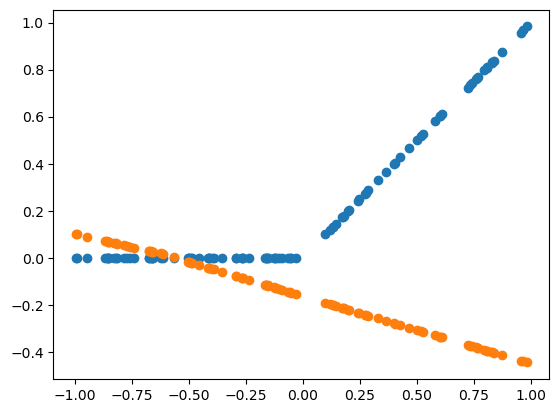

In [81]:
plt.scatter(x, t.relu(x))
plt.scatter(x, model(x).detach().numpy())